在 回归 (regression) 问题中，我们的目的是预测出如价格或概率这样连续值的输出。相对于分类(classification) 问题，分类(classification) 的目的是从一系列的分类出选择出一个分类 （如，给出一张包含苹果或橘子的图片，识别出图片中是哪种水果）。

本 notebook 使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

本示例使用 tf.keras API，相关细节请参阅 本指南。

In [0]:
# 使用 seaborn 绘制矩阵图 (pairplot)
!pip install -q seaborn

In [2]:
from __future__ import absolute_import, division,print_function,unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


###Auto MPG 数据集
该数据集可以从 UCI机器学习库 中获取.

获取数据
首先下载数据集。

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 4us/step


'/root/.keras/datasets/auto-mpg.data'

使用 pandas 导入数据集。

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path,names=column_names,
                          na_values="?",comment='\t',
                          sep=" ",skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


###数据清洗
数据集中包括一些未知值。

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

为了保证这个初始示例的简单性，删除这些行。

In [0]:
dataset = dataset.dropna()

"Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [7]:
origin = dataset.pop('Origin')
origin

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [8]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


###拆分训练数据集和测试数据集
现在需要将数据集拆分为一个训练数据集和一个测试数据集。

我们最后将使用测试数据集对模型进行评估。

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

###数据检查
快速查看训练集中几对列的联合分布。

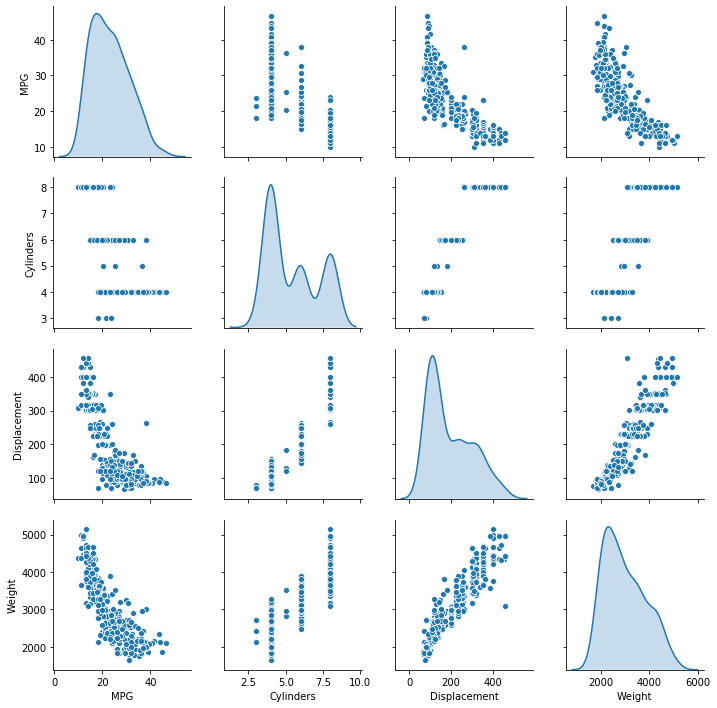

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

也可以查看总体的数据统计:

In [12]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


###从标签中分离特征
将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

###数据规范化
再次审视下上面的 train_stats 部分，并注意每个特征的范围有什么不同。

使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [0]:
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

我们将会使用这个已经归一化的数据来训练模型。

警告: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据，以及我们之前所获得独热码。这些数据包含测试数据集以及生产环境中所使用的实时数据。

##模型
###构建模型
让我们来构建我们自己的模型。这里，我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层。模型的构建步骤包含于一个名叫 'build_model' 的函数中，稍后我们将会创建第二个模型。 两个密集连接的隐藏层。

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
    layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
  return model

In [0]:
model = build_model()

###检查模型
使用 .summary 方法来打印该模型的简单描述。

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 model.predict 。

In [18]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.05876479],
       [-0.13643607],
       [-0.5886945 ],
       [-0.18769151],
       [-0.29555964],
       [-0.4045044 ],
       [-0.3104511 ],
       [ 0.09156755],
       [-0.24825206],
       [-0.09606563]], dtype=float32)

它似乎在工作，并产生了预期的形状和类型的结果

###训练模型
对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [19]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print("")
    print('.',end='')

EPOCHS = 1000

history = model.fit(normed_train_data,train_labels,
                    epochs=EPOCHS,validation_split=0.2,
                    verbose=0,callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用 history 对象中存储的统计信息可视化模型的训练进度。

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.734960,1.020855,2.734960,9.738566,2.434202,9.738566,995
996,2.717525,1.063096,2.717525,10.091740,2.526532,10.091741,996
997,2.846332,1.065822,2.846332,9.253150,2.330391,9.253151,997
998,2.700646,1.044734,2.700646,10.188214,2.470039,10.188214,998
999,2.622364,1.054606,2.622364,9.454095,2.367921,9.454096,999


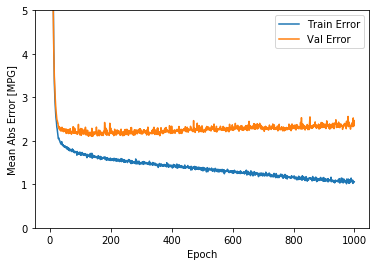

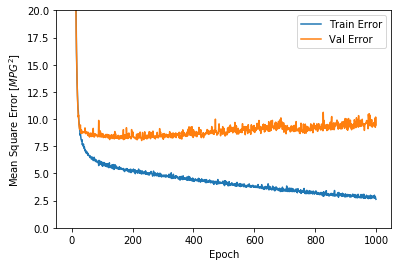

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'],hist['mae'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'],hist['mse'],label='Train Error')
  plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

你可以从这里学习到更多的回调。


....................................................

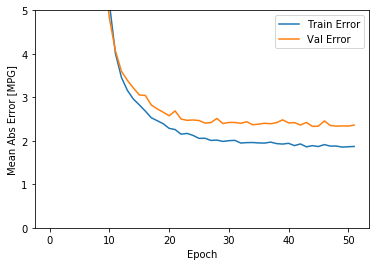

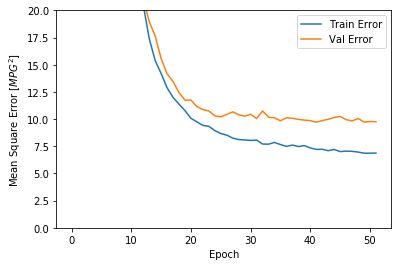

In [23]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(normed_train_data,train_labels,
                    epochs=EPOCHS,validation_split=0.2,
                    verbose=0,callbacks=[early_stop,PrintDot()])
plot_history(history)

如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 **测试集** 来泛化模型的效果如何，我们在训练模型时没有使用测试集。这告诉我们，当我们在现实世界中使用这个模型时，我们可以期望它预测得有多好。

In [24]:
loss,mae,mse = model.evaluate(normed_test_data,test_labels,verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.4250 - mae: 1.8402 - mse: 6.4250
Testing set Mean Abs Error:  1.84 MPG


###做预测
最后，使用测试集中的数据预测 MPG 值:



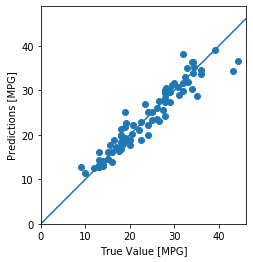

In [25]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels,test_predictions)
plt.xlabel('True Value [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

这看起来我们的模型预测得相当好。我们来看下误差分布。



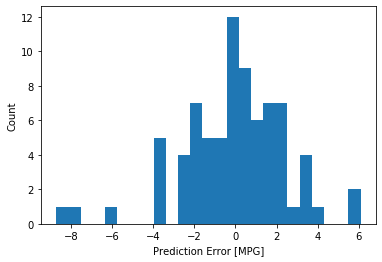

In [26]:
error = test_predictions - test_labels
plt.hist(error,bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

###结论
本笔记本 (notebook) 介绍了一些处理回归问题的技术。

* 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
* 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
* 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
* 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
* 早期停止是一种防止过度拟合的有效技术。